# Streamlit app dev and test



In [27]:
__author__      = 'Roy Gardner'

import networkx as nx
from networkx.readwrite import json_graph

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import csv
import sys

import ipywidgets as widgets

from scipy.spatial.distance import *


twenty_distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',\
                          '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',\
                          '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',\
                          '#000000']

def depth_first_search(matrix,query_index,max_depth=1,depth=1,vertices=[],visited=[]):
    """
    Recursive function to visit all vertices that are reachable from a query vertex.
    param matrix: The adjacency matrix representation of a graph
    param query_index: The row/column index which defines the query vertex
    param max_depth: How deep to go (for a bipartite graph the maximum is 2)
    param depth: Keeps track of how deep we have gone
    param vertices: Store found vertices
    param visited: Store visited vertices so we have a terminating condition
    return list of vertices
    """
    visited.append(query_index)
    # Index row - find connected head vertices in the query index row. In other words,
    # find the vertices that the query vertex point to
    vertices.extend([i for i,v in enumerate(matrix[query_index]) if v > 0 and not i in visited])
    if depth < max_depth:
        for i in vertices:
            if i in visited:
                continue
            vertices = depth_first_search(matrix,i,max_depth=1,depth=1,vertices=vertices,visited=visited)
    return vertices

def binary_to_adjacency(pp_data_dict):
    # Convert binary-valued relations matrix to a symmetric 
    # adjacency matrix representing an undirected graph
    # Rows and columns of the adjacency matrix are identical and
    # are constructed from the binary-valued matrix in row-column order.
    # The number of rows (and columns) in the adjacency matrix is therefore:
    # binary_matix.shape[0] +  binary_matix.shape[1]
    
    binary_matrix = pp_data_dict['pp_matrix']
    size = binary_matrix.shape[0] + binary_matrix.shape[1]
    adjacency_matrix = np.zeros((size,size))
    
    # Get the range of the bin matrix rows to generate the upper triangle
    # of the adjacency matrix
    row_index = 0
    col_index = binary_matrix.shape[0]
    adjacency_matrix[row_index:row_index + binary_matrix.shape[0],\
           col_index:col_index + binary_matrix.shape[1]] = binary_matrix
    # Add in the lower triangle
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T
    
    adj_vertices = []
    adj_vertices.extend(pp_data_dict['pp_agreement_ids'])
    adj_vertices.extend(pp_data_dict['pp_actor_ids'])

    return adjacency_matrix,adj_vertices

def get_query_matrix(query_indices,matrix,max_depth=1,operator='OR'):    
    found_indices = []
    for i,query_index in enumerate(query_indices):
        vertices = depth_first_search(matrix,query_index,max_depth=max_depth,vertices=[],visited=[])
        if i == 0:
            found_indices.extend(vertices)
        else:
            if operator == 'OR':
                found_indices = list(set(found_indices).union(set(vertices)))
            else:
                found_indices = list(set(found_indices).intersection(set(vertices)))
    # Add the query vertex to the found vertices
    found_indices.extend(query_indices)    
    found_indices = sorted(found_indices)
    # Extract the sub-matrix containing only the found vertices
    query_matrix = matrix[np.ix_(found_indices,found_indices)]
    return query_matrix,found_indices

def display_networkx_graph(query_matrix,vertex_indices,adj_vertices):
    node_labels = {i:adj_vertices[index] for i,index in enumerate(vertex_indices)}
    node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]
    graph = nx.from_numpy_matrix(query_matrix, create_using=nx.Graph)
    f = plt.figure(figsize=(16,16))
    pos = nx.spring_layout(graph) 
    nx.draw_networkx(graph,pos,labels=node_labels,node_color=node_colors,node_size=200,alpha=0.6)
    plt.grid(False)
    plt.show()
    
def get_peace_processes(data_dict):
    processes = [row[data_dict['links_header'].index('PPName')].strip() for row in data_dict['links_data']]
    return sorted(list(set(processes)))

def get_peace_process_data(process_name,data_dict):
    
    # Peace process data are in the links table so collect all edges assigned to the process
    pp_edges = [row for row in data_dict['links_data'] if row[data_dict['links_header'].\
                                                              index('PPName')].strip()==process_name]
    
    # Now we want the indices of peace process agreements and actors so we can extract the peace process
    # sub-matrix
    pp_agreement_ids = list(set([row[data_dict['links_header'].index('from_node_id')] for row in pp_edges]))
    pp_agreement_indices = [data_dict['agreement_vertices'].index(agreement_id) for\
                            agreement_id in pp_agreement_ids]
    
    pp_actor_ids = list(set([row[data_dict['links_header'].index('to_node_id')] for row in pp_edges]))
    pp_actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in pp_actor_ids]

    pp_matrix = data_dict['matrix'][np.ix_(pp_agreement_indices,pp_actor_indices)]
    pp_matrix = np.array(pp_matrix)
    pp_data_dict = {}
    pp_data_dict['pp_actor_ids'] = pp_actor_ids
    pp_data_dict['pp_agreement_ids'] = pp_agreement_ids
    pp_data_dict['pp_matrix'] = pp_matrix    
    return pp_data_dict

def get_cooccurrence_matrices(matrix):
    # Actor-actor co-occurence matrix for a peace process
    V = np.matmul(matrix.T,matrix)
    # Agreement-agreement co-occurence matrix
    W = np.matmul(matrix,matrix.T)
    return (V,W)


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:
def load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path):
    # Stash data in a dictionary
    data_dict = {}
    
    # Read the CSVs
    with open(data_path + nodes_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        nodes_header = next(reader)
        # Put the remaining rows into a list of lists
        nodes_data = [row for row in reader]

    with open(data_path + links_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        links_header = next(reader)
        # Put the remaining rows into a list of lists
        links_data = [row for row in reader]

    with open(data_path + agreements_dict) as f:
        agreements_dict = json.load(f)
    
    # Agreement are from vertices
    agreement_vertices = list(set([row[links_header.index('from_node_id')] for row in links_data]))
    # Actors are to vertices
    actor_vertices = list(set([row[links_header.index('to_node_id')] for row in links_data]))

    edge_dict = {}
    dates_dict = {}
    for row in links_data:
        if row[5] in edge_dict:
            edge_dict[row[5]].append(row[12])
        else:
            edge_dict[row[5]] = [row[12]]
        if not row[5] in dates_dict:
            a = row[1].split('/')
            dates_dict[row[5]] = int(''.join(a[::-1]))
    
    # Build a vertices dictionary with node_id as key and node row as the value
    vertices_dict = {row[nodes_header.index('node_id')]:row for row in nodes_data}

    # Collect all vertex types
    vertex_types = []
    for k,v in vertices_dict.items():
        type_ = v[nodes_header.index('type')]
        if len(type_) == 0:
            # This type is missing in node data
            type_ = 'AGT'
        vertex_types.append(type_)
    vertex_types = sorted(list(set(vertex_types)))

    # Build a colour map for types
    color_map = {type_:twenty_distinct_colors[i] for\
                 i,type_ in enumerate(vertex_types)}
    
    # Build the agreement-actor BVRM matrix - the core data structure
    matrix = []
    for agreement in agreement_vertices:
        row = [0]*len(actor_vertices)
        for i,actor in enumerate(actor_vertices):
            if actor in edge_dict[agreement]:
                row[i] = 1
        matrix.append(row)
    matrix = np.array(matrix)
    
    data_dict['agreements_dict'] = agreements_dict
    data_dict['dates_dict'] = dates_dict
    data_dict['nodes_data'] = nodes_data
    data_dict['nodes_header'] = nodes_header
    data_dict['links_data'] = links_data
    data_dict['links_header'] = links_header
    data_dict['agreement_vertices'] = agreement_vertices
    data_dict['actor_vertices'] = actor_vertices
    data_dict['vertices_dict'] = vertices_dict
    data_dict['color_map'] = color_map
    data_dict['matrix'] = matrix

    return data_dict

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)


## Get a peace process sub-matrix

- Create the binary-valued relation matrix containing only the agreements and actors of a defined peace process.
- Data are stored in pp_data_dict


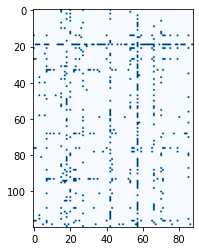

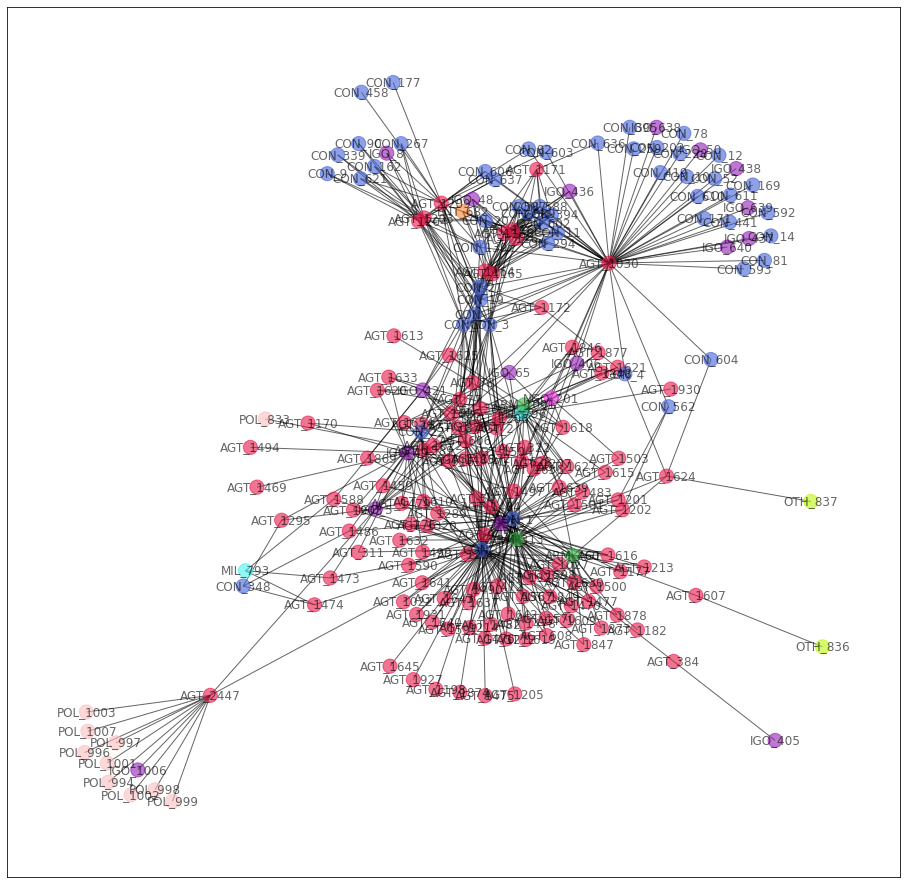

In [22]:

process_name = 'Bosnia peace process'
#process_name = 'Yemen peace process'
#process_name = 'Chad: Doha process'
#process_name = 'DRC: Eastern DRC processes'


pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

plt.imshow(pp_matrix,cmap=plt.cm.Blues)
plt.show()

# Display graph
adj_matrix,adj_vertices = binary_to_adjacency(pp_data_dict)
display_networkx_graph(adj_matrix,range(0,len(adj_vertices)),adj_vertices)


## Compute co-occurence matrices

Use a peace process binary-valued relation matrix to compute co-occurences:
- For a pair of actors, the number of agreements in common
- For a pair of agreements, the number of actors in common


In [12]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_upper = np.triu(co_matrices[0],k=1)
agreement_upper = np.triu(co_matrices[1],k=1)

actor_max = np.amax(actor_upper)
agreement_max = np.amax(agreement_upper)

print(actor_max)
print(agreement_max)


26
16


## Retrieving co-occurrence entities

Works for either:

- A set of agreements
- A set of actors


In [ ]:

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
#print(list(co_matrices[0]))

# Find agreements that a pair of actors have in common

# Define indices for a pair of actors

row_index = 0
col_index = 1

# Get the row from the transpose of pp matrix
row = pp_data_dict['pp_matrix'].T[row_index]
# Get the row from the pp matrix
col = pp_data_dict['pp_matrix'].T[col_index]


x = np.bitwise_and(row,col)
print(len(x)) # The number of agreements

# Number in co-occurrence cell
print(co_matrices[0][row_index][col_index])

print(len([v for v in x if v == 1]))


In [16]:

co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
#print(list(co_matrices[0]))

# Find agreements that a pair of actors have in common

# Define indices for a pair of actors

row_index = 0
col_index = 1

# Get the row from the transpose of pp matrix
row = pp_data_dict['pp_matrix'].T[row_index]
# Get the row from the pp matrix
col = pp_data_dict['pp_matrix'].T[col_index]


x = np.bitwise_and(row,col)
print(len(x)) # The number of agreements

# Number in co-occurrence cell
print(co_matrices[0][row_index][col_index])

print(len([v for v in x if v == 1]))


120
3
3


## Actor presence in time series of agreements

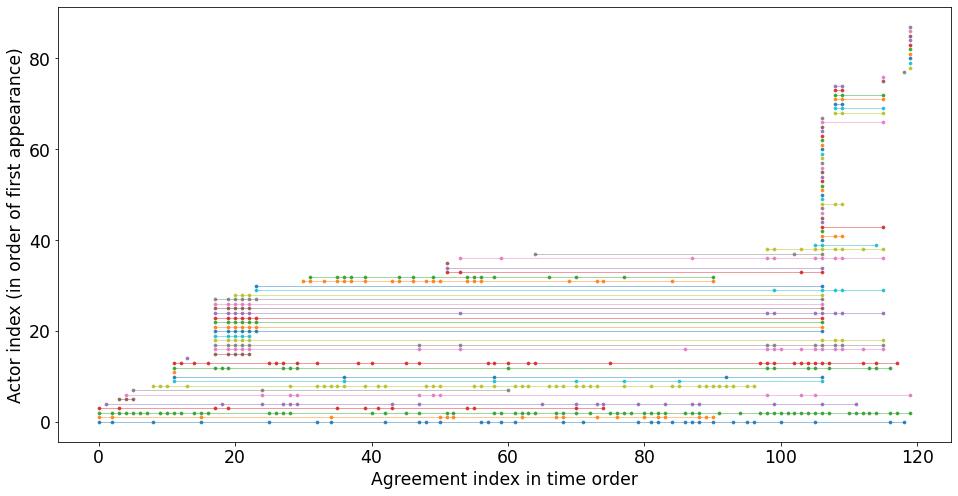

[18, 27, 57, 85, 15, 58, 17, 26, 42, 3, 6, 12, 53, 66, 44, 0, 7, 23, 25, 40, 54, 55, 59, 65, 71, 72, 75, 79, 1, 33, 38, 20, 70, 36, 50, 80, 43, 29, 22, 16, 2, 8, 13, 14, 21, 24, 28, 32, 35, 37, 39, 41, 46, 48, 51, 60, 61, 62, 63, 64, 69, 73, 74, 78, 81, 82, 83, 87, 9, 11, 30, 31, 45, 52, 68, 77, 84, 4, 5, 10, 19, 34, 47, 49, 56, 67, 76, 86]
UNMIBH


In [17]:
#print(data_dict['dates_dict'])

#print(pp_data_dict['pp_agreement_ids'])
pp_ag_ids = pp_data_dict['pp_agreement_ids']

t_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_date = data_dict['dates_dict'][agreement_id]
    t_list.append((i,ag_date))
# Sort by date    
t_list = sorted(t_list,key=lambda t:t[1])
    
# Build a time-order agreement-actor matrix
ordered_matrix = []
for t in t_list:
    ordered_matrix.append(pp_data_dict['pp_matrix'][t[0]])
    
ordered_matrix = np.array(ordered_matrix)
# Put actors in rows
ordered_matrix = ordered_matrix.T

# Now order actors by first appearance in process
row_indices = []
for i,row in enumerate(ordered_matrix):
    where = np.where(row==1)
    v = 0
    if len(where[0]) > 0:
        v = where[0][0]
    row_indices.append((i,v))
sorted_row_indices = [t[0] for t in sorted(row_indices,key=lambda t:t[1])]

sorted_matrix = ordered_matrix[np.ix_(sorted_row_indices)]

f = plt.figure(figsize=(16,8))
for i,row in enumerate(sorted_matrix):
    x = [j for j,x in enumerate(row) if x > 0]
    y = [i]*len(x)
    plt.scatter(x,y,alpha=0.9,linewidth=0.5,s=10)
    plt.plot(x,y,alpha=0.9,linewidth=0.5)
plt.xticks(fontsize='xx-large')    
plt.yticks(fontsize='xx-large')    
plt.ylabel('Actor index (in order of first appearance)',fontsize='xx-large')
plt.xlabel('Agreement index in time order',fontsize='xx-large')
plt.show()

print(sorted_row_indices)
print(data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][4]][5])


## Extract values from data dictionaries

In [18]:
print(data_dict['vertices_dict']['CON_264'])
print(pp_data_dict['pp_actor_ids'])

['Actor', '264', 'CON', 'CON_264', 'Country/State', 'Congo, Democratic Republic of the', 'DRC', 'Congo, Democratic Republic of the', 'COD', '89.0', 'Government of DR Congo (Zaire)', 'Government of the Democratic Republic of Congo (2019-)', 'Government of the Democratic Republic of Congo (1997-2001) | Government of the Democratic Republic of Congo (2001-2019) | Government of the Democratic Republic of Congo (2019-)', 'Congo, Democratic Republic of (Zaire) | CONGO, THE DEMOCRATIC REPUBLIC OF | Democratic Republic | Democratic Republic Congo | Republic Democratic Republic Congo', 'Congo, Democratic Republic of the is a Country/State in Africa. ', '', '', '', '', '', '', '', '']
['ENT_682', 'IGO_436', 'CON_12', 'NGO_201', 'IGO_405', 'POL_1002', 'IGO_65', 'CON_3', 'CON_606', 'CON_162', 'POL_997', 'CON_267', 'POL_833', 'CON_202', 'CON_82', 'IGO_49', 'IGO_406', 'IGO_5', 'ARM_313', 'POL_999', 'MIL_796', 'IGO_640', 'CON_2', 'CON_19', 'CON_610', 'CON_20', 'CON_348', 'ARM_460', 'IGO_438', 'CON_56

In [19]:
# Get actors in alpha order
actor_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5]) for vertex_id in\
                 pp_data_dict['pp_actor_ids']]
actor_options = sorted(actor_options,key=lambda t:t[1])
actor_options = [t[0] + ': ' + t[1] for t in actor_options]

# Get agreements in date order
agreement_options = [(vertex_id,data_dict['vertices_dict'][vertex_id][5],data_dict['dates_dict'][vertex_id])\
                     for vertex_id in pp_data_dict['pp_agreement_ids']]
agreement_options = sorted(agreement_options,key=lambda t:t[2])
agreement_options = [t[0] + ': ' + t[1] for t in agreement_options]


## Query peace process networks

### Query based on DFS in adjacency matrix

Notes:
- That depth 2 (and above) will yield the entire graph because the graph is bipartite.
- Should be either/or with respect to entity type.


AGT_2447 Political agreement on principles for ensuring a functional Bosnia and Herzegovina that advances on the European path



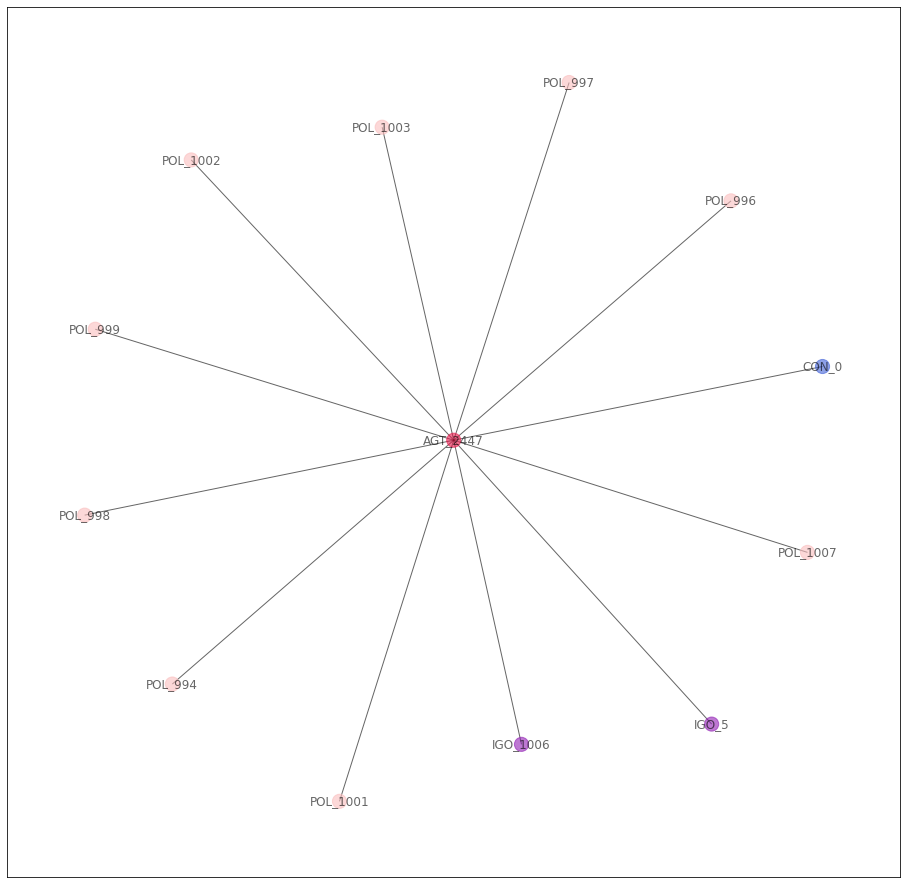

In [29]:

# Convert a peace process BVRM to an adjacency matrix
adj_matrix,adj_vertices = binary_to_adjacency(pp_data_dict)

query_vertices = ['CON_19','CON_20','CON_21']
query_vertices = ['IGO_5','CON_20','CON_4']
query_vertices = ['AGT_2447']
for vertex in query_vertices:
    print(vertex,data_dict['vertices_dict'][vertex][5])
print()

query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator='OR')
display_networkx_graph(query_matrix,found_indices,adj_vertices)


## Actor diagonal by stage

In [30]:
stage_dict = {}
stage_dict['Cea'] = [1,'Ceasefire related']
stage_dict['Pre'] = [2,'Pre-negotiation process']
stage_dict['SubPar'] = [3,'Partial Framework - substantive']
stage_dict['SubComp'] = [4,'Comprehensive Framework - substantive']
stage_dict['Ren'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Imp'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Oth'] = [0,'']

# Map agreements on to stages
stage_map = {}
for i,agreement_id in enumerate(pp_data_dict['pp_agreement_ids']):
    ss_id = agreement_id.split('_')[1]
    if ss_id in data_dict['agreements_dict']:
        stage_map[i] = stage_dict[data_dict['agreements_dict'][ss_id]['Stage']][0]
    else:
        stage_map[i] = 0
    
print(len(stage_map))
print(len(pp_data_dict['pp_agreement_ids']))

print(len([v for _,v in stage_map.items() if v == 0]))


120
120
0


[('Malaysia', 1), ('UNMIBH', 1), ('Independent Bloc', 1), ('Social Democratic Party of Bosnia and Herzegovina', 1), ('Croatian Democratic Union', 1), ('Switzerland', 1), ('Democratic Front', 1), ('Office of the United Nations High Commissioner for Human Rights', 1), ('North Macedonia', 1), ('International Monetary Fund', 1), ('Portugal', 1), ('Our Party', 1), ('Norway', 1), ('Pakistan', 1), ('Morocco', 1), ('Exchange Comisssion', 1), ('Netherlands', 1), ('Alliance of Independent Social Democrats', 1), ('Ukraine', 1), ('People and Justice', 1), ('Slovenia', 1), ('United Srpska', 1), ('Belgium', 1), ('Jordan', 1), ('World Bank', 1), ('Saudi Arabia', 1), ('Organization for Security and Cooperation in Europe', 1), ('European Council', 1), ('Council of Europe', 1), ('European Bank for Reconstruction and Development', 1), ('Ireland', 1), ("People's European Union of Bosnia and Herzegovina", 1), ('South Korea', 1), ('Sweden', 1), ('International Conference on the Former Yugoslavia', 1), ('Slo

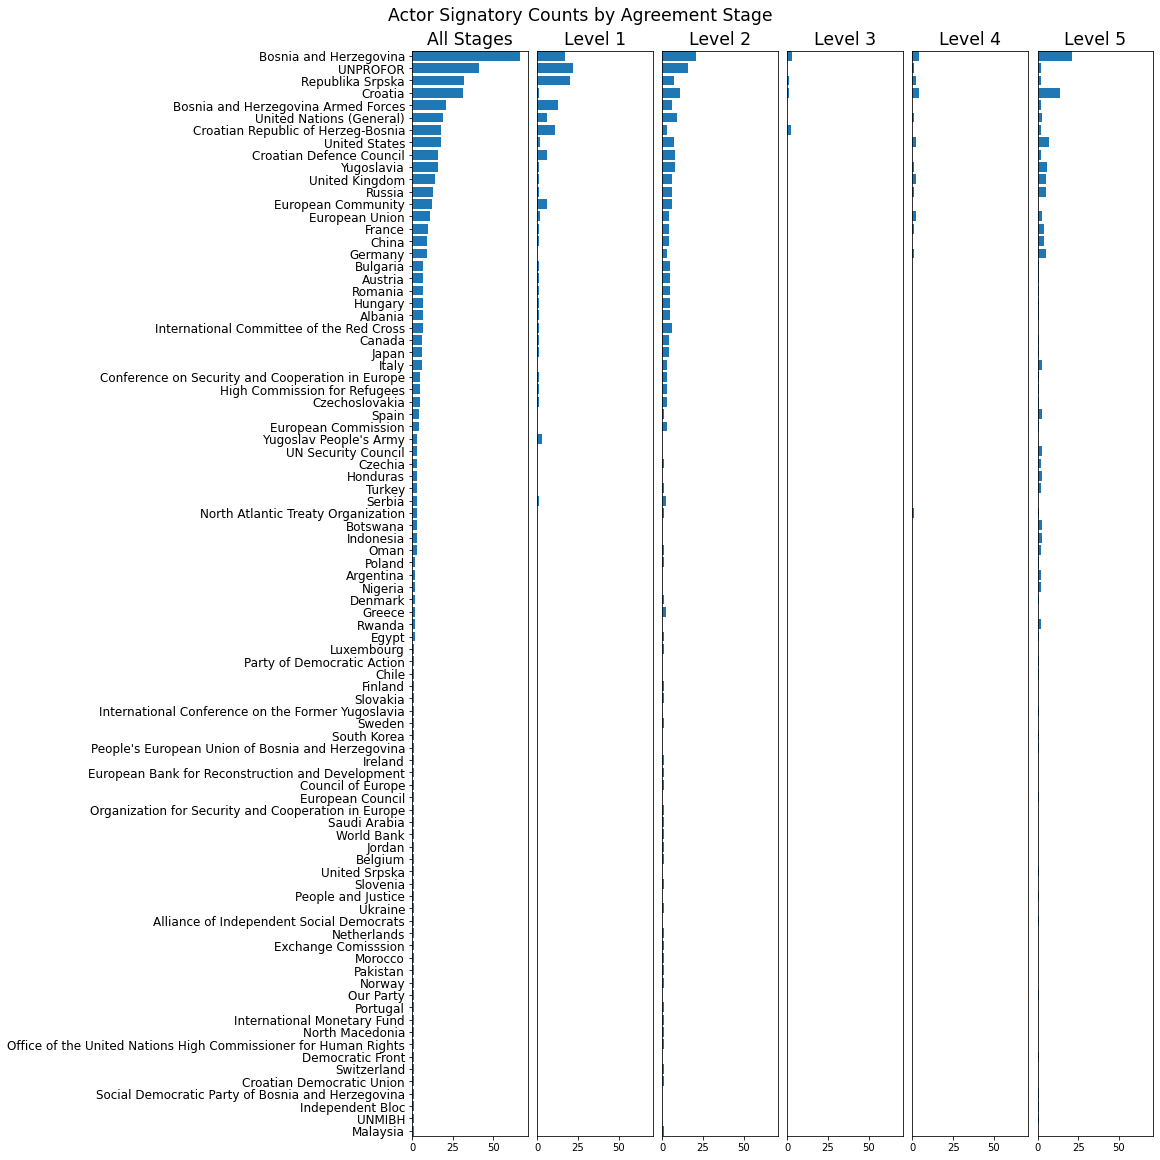

In [31]:
from matplotlib.gridspec import GridSpec


co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
values = [t[1] for t in z]
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")

gs = GridSpec(1, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax1.barh(range(0,len(actor_diag)),values)
ax1.set_yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
ax1.set_xlim(0,max(values)+5)
ax1.margins(y=0)
ax1.set_title('All Stages',fontsize='xx-large')

print(z)
print()

stage_levels = [1,2,3,4,5]
for i,stage_level in enumerate(stage_levels):
    stage_agreement_indices = [k for k,v in stage_map.items() if v == stage_level]

    stage_matrix = pp_data_dict['pp_matrix'][np.ix_(stage_agreement_indices)]

    co_matrices = get_cooccurrence_matrices(stage_matrix)
    
    # Same order as all agreements so y-axes are consistent
    actor_diag = np.diag(co_matrices[0])
    x = list(zip(labels,actor_diag))
    x = sorted(x,key=lambda t:[g[0] for g in z].index(t[0]))
    #print(x)
    print()
    
    ax = fig.add_subplot(gs[0,i+1])
    ax.barh(range(0,len(actor_diag)),[t[1] for t in x])

    ax.set_yticks([],[])
    ax.set_xlim(0,max(values)+5)
    ax.margins(y=0)
    ax.set_title('Level ' + str(stage_level),fontsize='xx-large')


fig.suptitle('Actor Signatory Counts by Agreement Stage',fontsize='xx-large')

plt.show()

88


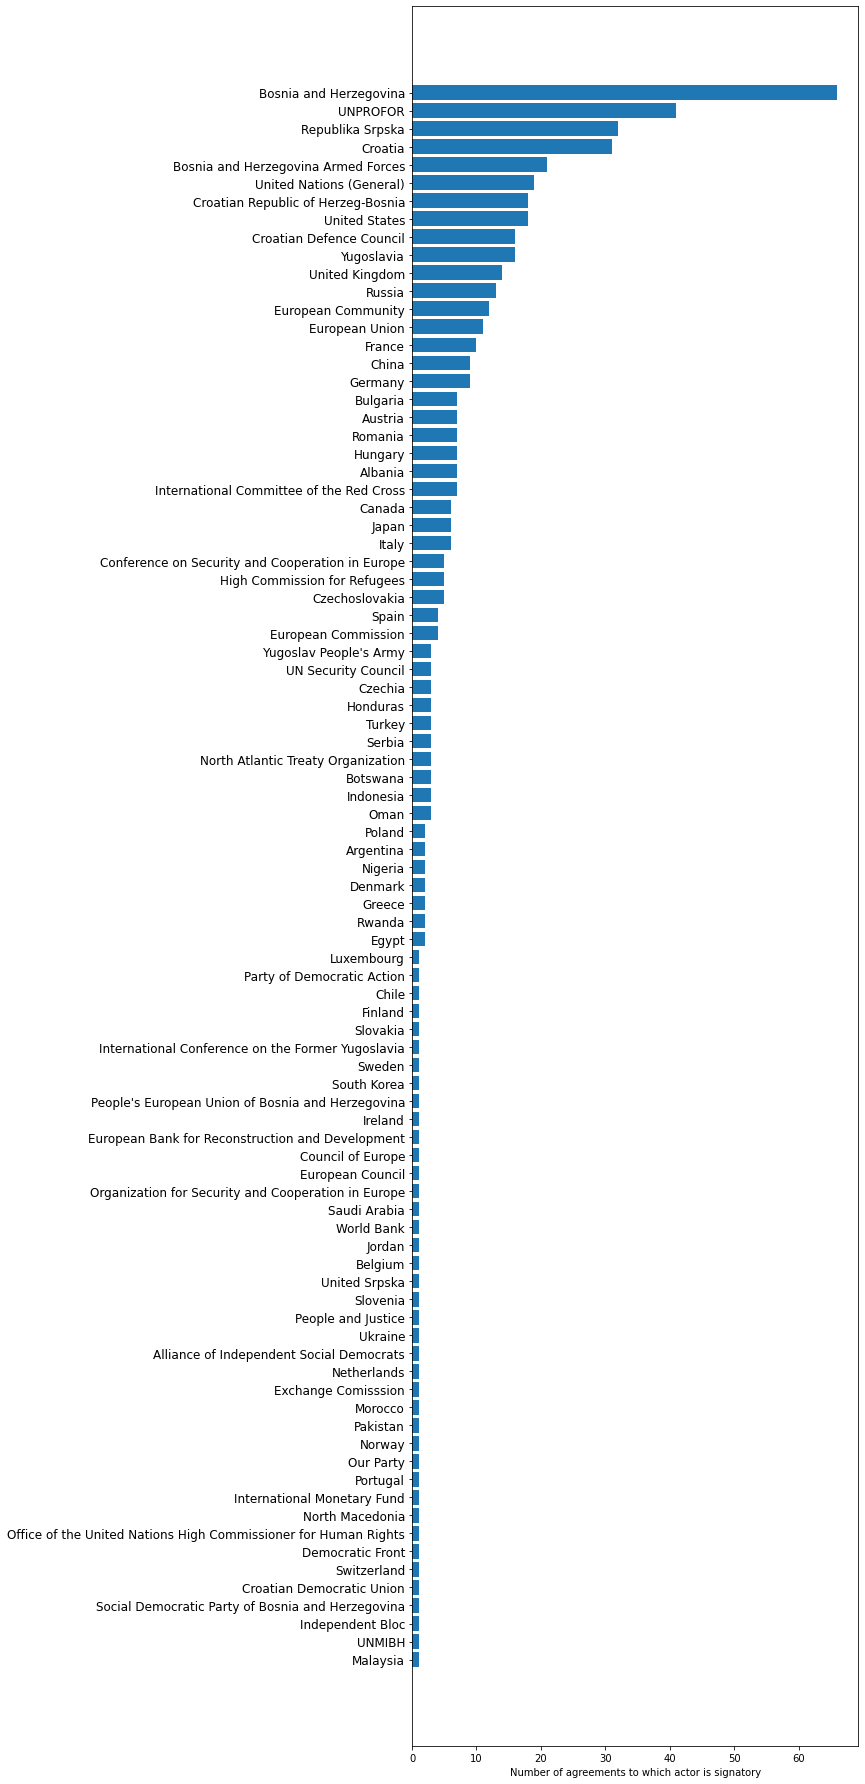

In [32]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
print(len(z))

f = plt.figure(figsize=(8,32))
plt.barh(range(0,len(actor_diag)),[t[1] for t in z])
plt.yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
plt.xlabel('Number of agreements to which actor is signatory')
plt.show()


## Build process-actor matrix

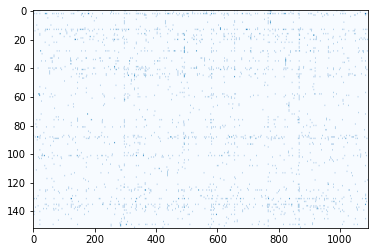

In [33]:
# Build a peace process-actor matrix

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)

# Get list of peace processes
processes = get_peace_processes(data_dict)


process_matrix = np.zeros((len(processes),len(data_dict['actor_vertices'])), dtype=int)

for i,process_name in enumerate(processes):
    process_data = get_peace_process_data(process_name,data_dict)
    actor_marginal = [sum(row) for row in process_data['pp_matrix'].T]
    actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in process_data['pp_actor_ids']]
    for j,v in enumerate(actor_marginal):
        if v > 0:
            process_matrix[i][actor_indices[j]] = 1

plt.imshow(process_matrix,cmap=plt.cm.Blues,aspect='auto')

proc_co = get_cooccurrence_matrices(process_matrix)



In [ ]:


data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
matrix = data_dict['matrix']


# Matrix plot routines
print(matrix.shape)
f = plt.figure(figsize=(32,32))
plt.imshow(complete_matrix,aspect='auto')
plt.show()

# Get the column marginals
col_marginals = []
for row in complete_matrix.T:
    col_marginals.append(sum(row))


plt.plot(range(0,len(col_marginals)),col_marginals)
plt.show()

max_i = col_marginals.index(max(col_marginals))
max_actor = to_vertices[max_i]
print(max_actor,vertices_dict[max_actor][5])


In [ ]:
x = np.argsort(col_marginals)[::-1][:5]
print("Indices:",x)
